<a href="https://colab.research.google.com/github/jxareas/AI-102-AIEngineer/blob/master/Regresion_lineal_l2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regresion Lineal L2 - Regularizacion de Tikhonov**

## El presente notebook explora el tema de la Regresión en el Aprendizaje de Maquinas. Todos los algoritmos en este capítulo se implementan manualmente utilizando metodos numericos de Álgebra Lineal.

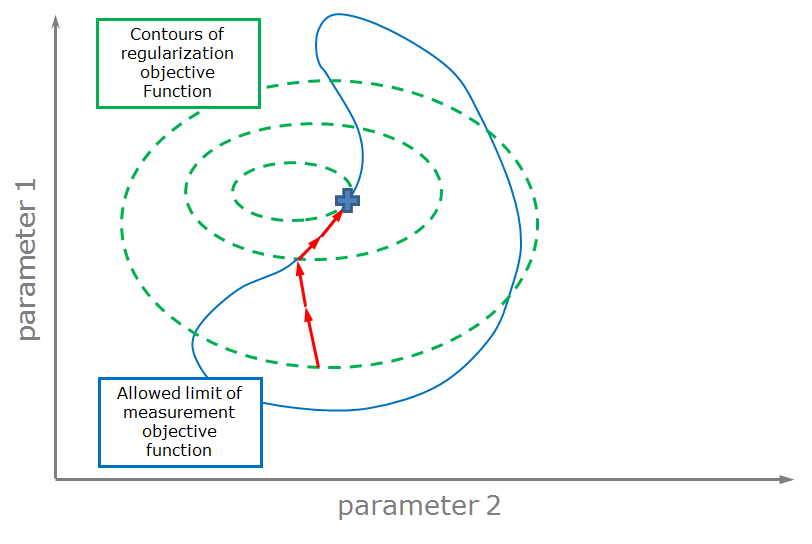

### Aquí hay algunos de los temas cubiertos por este notebook:

- Realizar Análisis Exploratorio de Datos para descubrir patrones.
- Usar Regresión Lineal a través de la Ecuación Normal para predecir variables objetivo cuantitativas.
- Aplicar Regularización de Tikhonov a un modelo de Regresión Lineal.
- Utilizar semillas aleatorias para controlar la reproducibilidad.


**Realizado por:**
[@jxareas](https://github.com/jxareas)
[@emit2019](https://github.com/emit2019)

In [ ]:
# %% Importando las librerias y realizando la carga de datos

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# **Analisis Exploratorio de Datos**

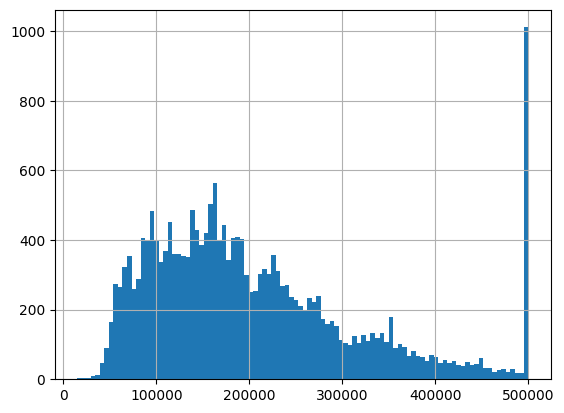

In [ ]:
# %% Analisis exploratorio de datos

# Cargando los datos
df = pd.read_feather("https://raw.githubusercontent.com/jxareas/ml-zoomcamp-2022/master/02-regression/data/housing.feather")

# Analizando la distribucion del valor mediano de una casa
df.median_house_value.hist(bins=100)
plt.show()  # Posee una distribucion sesgada hacia la derecha

In [ ]:
# Tamanio del data frame
df.shape

(20640, 11)

# **Transformacion Logaritmica**
Se transforma el valor de la variable objetivo utilizando una transformacion logaritmica para controlar la asimetria de la distribucion (falta de linealidad en la relacion entra la variable objetivo y los predictores).

$ f(x) = log(1+x)$

In [ ]:
# Realizando una seleccion de caracteristicas
features = ['latitude', 'longitude', 'housing_median_age', 'total_rooms',
            'total_bedrooms', 'population', 'households', 'median_income']
target = ['median_house_value_log']
df['median_house_value_log'] = np.log1p(df.median_house_value) # Realizando una transformacion logaritmica para controlar asimetria

Regularización de Tikhonov

Objetivo:
La regularización de Tikhonov busca minimizar una función de costo que combina dos términos: el término de ajuste a los datos y el término de penalización por la complejidad del modelo.

Fórmula:
La función de costo regularizada de Tikhonov se define como:

$ J(\theta) = J_{\text{data}}(\theta) + \alpha \|\theta\|_2^2 $

Donde:
- $ J_{\text{data}}(\theta) $ es la función de costo basada en los datos.
- $ \alpha $ es el parámetro de regularización, que controla la fuerza de la regularización.
- $ \|\theta\|_2^2 $ es la norma $ L2 $ (norma euclidiana al cuadrado) de los parámetros del modelo $ \theta $.

Interpretación:
- El término $ J_{\text{data}}(\theta) $ mide qué tan bien el modelo se ajusta a los datos.
- El término $ \alpha \|\theta\|_2^2 $ penaliza los valores grandes en los parámetros $ \theta $, favoreciendo modelos más simples y evitando el sobreajuste.


In [ ]:
# Aplicando metodos numericos

# Este fragmento de código contiene las funciones necesarias para mezclar el dataframe,
# entrenar el modelo de regresión lineal y hacer la división entre entrenamiento y prueba.


def shuffle(data, random_seed):
    """ Returns a shuffled version of the original dataframe
    :param pd.DataFrame data: a dataframe
    :param float random_seed: a seed that controls reproducibility
    :return: Shuffled data
    :rtype: pd.DataFrame
    """
    n = len(data)
    np.random.seed(random_seed)
    index = np.arange(n)
    np.random.shuffle(index)

    shuffled_data = data.iloc[index].reset_index(drop=True)
    return shuffled_data


def split(data, validation_percent=0.2, test_percent=0.2):
    """
    :param pd.DataFrame data: a dataframe
    :param float validation_percent: validation set percentage
    :param float test_percent: test set percentage
    :return: the train, validation and test set
    :rtype: tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
    """
    n = len(data)
    n_val = int(n * validation_percent)
    n_test = int(n * test_percent)
    n_train = n - n_val - n_test

    df_train = data.iloc[:n_train]
    df_val = data.iloc[n_train:n_train + n_val]
    df_test = data.iloc[n_train + n_val:]

    return df_train, df_val, df_test


def prepare_validation_framework(data, random_seed=42):
    """ Prepares the validation framework for a machine learning model
    :param pd.DataFrame data: a dataframe
    :param float random_seed: a seed that controls reproducibility
    :return: the train, validation and test set, separated by features (X) and target (y)
    :rtype: tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]
    """
    data = shuffle(data.copy(), random_seed)

    n = len(data)
    n_val = int(n * 0.2)  # Validation size
    n_test = int(n * 0.2)  # Test size
    n_train = n - n_val - n_test  # Train size

    # Performing the train-test split
    df_train = data.iloc[:n_train][features]
    df_val = data.iloc[n_train:n_train + n_val][features]
    df_test = data.iloc[n_train + n_val:][features]

    target_train = data.iloc[:n_train][target].squeeze()
    target_val = data.iloc[n_train:n_train + n_val][target].squeeze()
    target_test = data.iloc[n_train + n_val:][target].squeeze()

    return df_train, df_val, df_test, target_train, target_val, target_test


def train_linear_regression_reg(X, y, r=0.0):
    """ Estimates the parameters of a regularized linear regression model
    :param np.ndarray X: a matrix
    :param np.ndarray y: a vector
    :param np.ndarray r: the Lagrange multiplier
    :return: the beta coefficients of the model
    :rtype: np.ndarray
    """
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    # Regularization
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full


def train_linear_regression(X, y):
    """ Estimates the parameters of a linear regression model
    :param X: a matrix
    :param y: a vector
    :return: the beta coefficients of the model
    :rtype: np.ndarray
    """
    ones = np.ones(len(X))
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    betas = XTX_inv.dot(X.T).dot(y)

    return betas


def predict(X, betas):
    """ Predicts values using a linear regression model
    :param np.ndarray X: Design matrix
    :param np.ndarray betas: Beta coefficients
    :return: Estimated target values
    :rtype: np.ndarray
    """
    return betas[0] + X.dot(betas[1:])


def rmse(y, y_hat):
    """ Computes the Root Mean Square Error
    :param y: vector
    :param y_hat: estimated vector
    :return: the root-mean-square error
    :rtype: np.ndarray
    """
    squared_errors = (y - y_hat) ** 2
    mean_squared_error = np.mean(squared_errors)
    return np.sqrt(mean_squared_error)

In [ ]:
# Necesitamos manejar los valores faltantes para las columnas con nulos.
# Tenemos dos opciones: llenarlos con 0 o con la media de esta variable.
# Prueba ambas opciones. Para cada una, entrena un modelo de regresión lineal sin regularización utilizando el código de las lecciones.
# Para calcular la media, ¡utiliza solo los datos de entrenamiento!
# Usa el conjunto de validación para evaluar los modelos y compara el RMSE de cada opción.
# Redondea los puntajes de RMSE a 2 dígitos decimales usando round(score, 2).
# ¿Qué opción da un mejor RMSE?

# %% Solucion 1: Reemplazar con 0

# Preparando el train-test-validation split
x_train, x_val, x_test, y_train, y_val, y_test = prepare_validation_framework(df, random_seed=42)

zero_linear_model = train_linear_regression(x_train.fillna(0).values, y_train.values)
zero_predicted_y_val = predict(x_val, zero_linear_model)
zero_rmse = rmse(y_val.values, zero_predicted_y_val)
print(zero_rmse)

# %% Solucion 2: Reemplazar con la media
total_bedrooms_mean = x_train.total_bedrooms.mean()
mean_linear_model = train_linear_regression(x_train.fillna(total_bedrooms_mean).values, y_train.values)
mean_predicted_y_val = predict(x_val, mean_linear_model)
mean_rmse = rmse(y_val.values, mean_predicted_y_val)
print(mean_rmse)

0.32953303652278954
0.32901954390060556


In [ ]:
# %% Ahora vamos a entrenar una regresión lineal regularizada.
# Para esta pregunta, completa los valores faltantes con 0 (l2).
# Prueba diferentes valores de r de esta lista: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
# Utiliza el RMSE para evaluar el modelo en el conjunto de validación.
# Redondea los puntajes de RMSE a 2 dígitos decimales.
# ¿Qué valor de r da el mejor RMSE?

# NOTA : EL MULTIPLICADOR (multiplier) lambda es el hiperparametro

multipliers = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
rmse_per_multiplier = dict()
for multiplier in multipliers:
    model = train_linear_regression_reg(x_train.fillna(0).values, y_train.values, r=multiplier)
    model_prediction_val = predict(x_val, model)
    model_rmse = rmse(y_val.values, model_prediction_val)
    rmse_per_multiplier[multiplier] = model_rmse

from pprint import pprint
pprint(rmse_per_multiplier) # El 0 posee el menor

{0: 0.32953303652278954,
 1e-06: 0.3295330361648495,
 0.0001: 0.32953300097042265,
 0.001: 0.3295327038669567,
 0.01: 0.32953193659925983,
 0.1: 0.3296947205397395,
 1: 0.3337887220004341,
 5: 0.3392485345505988,
 10: 0.3406063807809593}


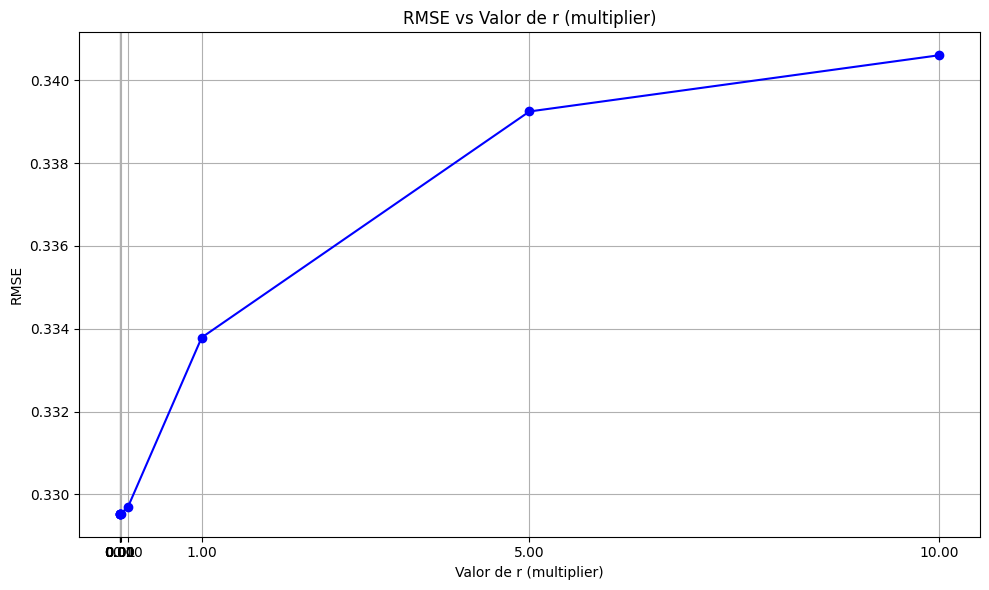

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(multipliers, list(rmse_per_multiplier.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Valor de r (multiplier)')
plt.ylabel('RMSE')
plt.title('RMSE vs Valor de r (multiplier)')
plt.grid(True)
plt.xticks(multipliers)
plt.tight_layout()
plt.show()

In [ ]:
model

array([-7.89931183e-01, -1.78100022e-01, -1.53050818e-01,  4.83161595e-03,
       -3.29541256e-05,  1.17886470e-04, -2.10274098e-04,  7.58872926e-04,
        1.88177852e-01])